# Test space.

In [5]:
import sys
import os
import math
import vaex  # The holy grail.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/Users/Jake/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

# Neat tricks.
from itertools import chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Local imports. 
from PyUtils.Utils_Files import makeDirs, make_str_title_friendly, check_overwrite
from PyUtils.Utils_Plotting import (change_cmap_bkg_to_white, save_plots_to_outpath, make_1D_dist, get_stats_1Dhist, 
                                    get_stats_2Dhist, hist_y_label, make_2by2_subplots_for_ratioplots,
                                    add_underoverflow_entries, make_stats_legend_for_1dhist, make_stats_legend_for_2dhist, 
                                    make_stats_legend_for_gaus_fit)
from PyUtils.Utils_Physics import theta2pseudorap, pseudorap2theta, calc_dR, calc_dphi, perc_diff
from PyUtils.Utils_StatsAndFits import gaussian, fit_with_gaussian, iterative_fit_gaus
from PyUtils.Utils_Collection_Helpers import weave_lists
from d0_Utils.d0_cls import KinematicBin, KinBinOrganizer, GraphLine
from d0_Utils.d0_cls import KinBinOrganizer, GraphLine

from d0_Utils.d0_fns import (make_binning_array, shift_binning_array, get_subset_mask, 
                             make_kinem_subplot, calc_x_err_bins, combine_cut_list, calc_bin_widths,
                            find_equal_hist_divisions, find_equal_hist_regions_unbinned, collapse_eta_bin_edges)
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

plt.rcParams.update({'figure.max_open_warning': 10})    # Related to saving memory and opening plots.

# pd.options.display.max_columns = 23
pd.options.display.max_columns = None

plt.style.use('cmsstyle_plot')
# plt.style.use("grid_multiple_plots")

In [2]:
%%time
#---------- Use vaex to open these ----------#
# infile_path_MC_2016 = '/Users/Jake/Desktop/MC_2016.h5'
# infile_path_MC_2016_hdf = '/Users/Jake/Desktop/MC_2016.hdf5'
infile_path_MC_2016_hdf_trimmed = "/Users/Jake/Desktop/MC_2016_trimmed.hdf5"
# infile_path_MC_2016_csv = '/Users/Jake/Desktop/MC_2016.csv'
# infile_path_MC_2016_arrow = '/Users/Jake/Desktop/MC_2016.arrow'

# infile_path_MC_2017 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2017.feather'
# infile_path_MC_2018 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2018.feather'

# THESE ARE READ DIRECTLY INTO MEMORY! AVOID AT ALL COSTS!!!
# df_MC_2016 = pd.read_feather(infile_path_MC_2016)
# df_MC_2017 = pd.read_feather(infile_path_MC_2017)
# df_MC_2018 = pd.read_feather(infile_path_MC_2018)

# df_MC_2016 = pd.read_hdf(infile_path_MC_2016)
# df_MC_2017 = pd.read_hdf(infile_path_MC_2017)
# df_MC_2018 = pd.read_hdf(infile_path_MC_2018)

vdf = vaex.open(infile_path_MC_2016_hdf_trimmed)

# Get names of columns for each muon.
col_ls = vdf.column_names
col_mu1_ls = [x for x in col_ls if x[-1] == "1"]
col_mu2_ls = [x for x in col_ls if x[-1] == "2"]
col_common_ls = [x for x in col_ls if x[-1] not in ["1","2"]]

msg = "[WARNING] There is a problem with number of columns or column naming!"
assert len(col_mu1_ls) + len(col_mu2_ls) + len(col_common_ls) == len(col_ls), msg

vdf_mu1 = vdf.drop(col_mu1_ls + col_mu2_ls)
vdf_mu2 = vdf.drop(col_mu1_ls + col_mu2_ls)
# vdf_mu2 = vdf.drop(col_mu1_ls)

In [224]:
# Gives vdf_mu1 all the muon1 values and similarly for muon2.
for col_mu1, col_mu2 in zip(col_mu1_ls, col_mu2_ls):
    vdf_mu1[col_mu1[:-1]] = getattr(vdf, col_mu1).values
    vdf_mu2[col_mu2[:-1]] = getattr(vdf, col_mu2).values

In [227]:
# Put muon1 and muon2 info together into single vaex DataFrame.
vdf_concat = vaex.concat([vdf_mu1, vdf_mu2])

# For some reason, don't have to call .values here.
vdf_concat["d0BSq"] = vdf_concat.d0BS * vdf_concat.Id / -13.  

# HERE IMPLEMENT MASSZ AND dR CUTS!

In [229]:
vdf_concat

#,massZ,massZErr,weight,GENmass2l,nFSRPhotons,index,pT,eta,phi,m,d0BS,d0PV,Id,Tight,pterr,genLep_pt,genLep_eta,genLep_phi,d0BSq
<i style='opacity: 0.6'>0</i>,103.72890561461452,1.111374476296364,1.0073400735855105,105.28272285816776,0,0,54.12628555297852,-0.8569425940513611,1.9260731935501096,0.10570000112056732,-0.0007386772194877268,-3.893432221957482e-05,13,1,0.575229823589325,54.23695373535156,-0.8568867444992065,1.9260679483413696,0.0007386772194877268
<i style='opacity: 0.6'>1</i>,91.83129994511332,1.0997841022849817,0.9984466433525084,92.30324006750271,0,1,68.71662139892578,1.574044942855835,2.6688482761383057,0.10570000112056732,-0.00302798836492002,-0.0008567695040255785,-13,1,1.420867681503296,70.5456314086914,1.5744500160217283,2.668697595596313,-0.00302798836492002
<i style='opacity: 0.6'>2</i>,93.61433620397928,1.19376529489286,1.016097903251648,92.93868043209451,0,2,47.15994644165039,-1.29828941822052,2.271371841430664,0.10570000112056732,-0.0017863643588498235,-0.0002777381450869143,-13,1,0.946391761302948,46.58187866210938,-1.2983626127243042,2.271397829055786,-0.0017863643588498235
<i style='opacity: 0.6'>3</i>,95.04622744089286,0.7979542783064814,0.9914446473121644,94.86266053067136,0,3,50.57381057739258,-0.8000861406326294,1.6780434846878052,0.10570000112056732,-0.0008950263727456332,-0.00025277366512455046,13,1,0.6223649382591248,50.56411361694336,-0.8005778193473816,1.6780730485916138,0.0008950263727456332
<i style='opacity: 0.6'>4</i>,90.02289486675134,0.745634174249191,0.989396631717682,90.513661017507,0,4,47.95061874389648,-0.3928700089454651,-1.648326754570007,0.10570000112056732,-0.004959595855325461,-0.0011026833672076464,-13,1,0.5198323726654053,47.395591735839844,-0.3930700421333313,-1.6483359336853027,-0.004959595855325461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"<i style='opacity: 0.6'>31,450,215</i>",88.55506445123969,1.4167492285056795,0.9999793767929076,88.35657797873606,0,15725105,33.34342575073242,0.7972239255905151,-2.9402587413787837,0.10570000112056732,0.0014905005227774384,-0.00021465588361024857,-13,1,0.3491708040237427,32.50773239135742,0.7976476550102234,-2.939932584762573,0.0014905005227774384
"<i style='opacity: 0.6'>31,450,216</i>",90.14991207924028,0.8480344589474049,1.0009995698928833,89.85768946094572,0,15725106,39.15347290039063,0.4853180646896362,0.2666405439376831,0.10570000112056732,9.198309271596372e-05,-0.0003470729570835829,13,1,0.40624862909317017,39.310340881347656,0.4851822555065155,0.2665365934371948,-9.198309271596372e-05
"<i style='opacity: 0.6'>31,450,217</i>",89.56386345745943,0.5864689747252789,0.9878479242324828,89.96713042141927,0,15725107,32.373828887939446,-0.12664073705673218,2.107879877090454,0.10570000112056732,-0.0020394627936184406,0.0006571307312697173,13,1,0.2754319310188293,32.67123413085937,-0.12640045583248138,2.107748746871948,0.0020394627936184406
"<i style='opacity: 0.6'>31,450,218</i>",74.36081408013929,0.6417170337892041,0.9933130741119384,73.71136585174341,0,15725108,23.83549499511719,-1.0358304977416992,0.19804823398590088,0.10570000112056732,-0.0044174762442708015,-0.011666742153465748,13,1,0.33980438113212585,23.210649490356445,-1.036239504814148,0.1977938711643219,0.0044174762442708015


In [296]:
# Best bins.

equal_entry_bin_edges_eta = [0.0, 0.2, 0.395, 0.6, 0.805, 1.02, 1.25, 1.49, 1.75, 2.05, 2.4]
equal_entry_bin_edges_pT  = [5.0, 23.01, 29.06, 33.45, 37.05, 40.18, 43.04, 45.99, 50.46, 60.77, 200.0]
equal_entry_bin_edges_pT_mod  = [5.0, 7, 9.8, 13.72, 19.21, 23.01, 29.06, 33.45, 37.05, 40.18, 43.04, 45.99, 50.46, 60.77, 200.0]
equal_entry_bin_edges_pT_sevenfifths = [7.0, 9.8, 13.720000000000002, 19.208000000000006, 26.89120000000001, 37.647680000000015, 52.706752000000016, 73.78945280000002, 103.30523392000002]
equal_entry_bin_edges_qd0 = [-0.20014, -0.00257, -0.00166, -0.00103, -0.0005, -1e-05, 0.00048, 0.001, 0.00163, 0.00254, 0.19913]

# Attempting for loop over pT vs. q*d0 plots.

In [307]:
%%time
%config InlineBackend.figure_format = 'retina'

outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_vs_qd0__eta_binning/test5.pdf"

with PdfPages(outpath) as pdf:
    for k in range(len(equal_entry_bin_edges_eta)-1):
        this_eta = equal_entry_bin_edges_eta[k]
        next_eta = equal_entry_bin_edges_eta[k+1]
    
        # f, ax = plt.subplots(figsize=(12.8, 9.6))
        f, ax = plt.subplots()

        x_2D_bins = equal_entry_bin_edges_qd0
        y_2D_bins = equal_entry_bin_edges_pT_sevenfifths

        x_label = r"$q(\mu^{\pm, \mathrm{REC} }) * d_{0}^{ \mathrm{BS} }$ [cm]"
        y_label = r"$p_{T}^{\mathrm{REC}}$ [GeV]"
        title = r"$%.1f < \left| \eta^{\mathrm{REC}} \right| < %.1f$" % (this_eta, next_eta)

        ax.set_xlabel(x_label)#, fontsize=label_size)
        ax.set_ylabel(y_label)#, fontsize=label_size)
        ax.set_title(title)#, fontsize=label_size)

        # Stats: 
        stat_text_x = 0.19
        stat_text_y = 0.88

        # x_vals = vdf_concat.d0BSq.values
        # y_vals = vdf_concat.pT.values
        selec1 = (np.abs(vdf_concat.eta) > this_eta) & (np.abs(vdf_concat.eta) < next_eta)
        selec2 = vdf_concat.eta
        x_vals = vdf_concat.evaluate("d0BSq", selection=selec)
        y_vals = vdf_concat.evaluate("pT", selection=selec)

        stats_ls = get_stats_2Dhist(x_vals, y_vals)
        # leg_label = cuts + "\n" + make_stats_legend_for_2dhist(stats_ls)
        leg_label = make_stats_legend_for_2dhist(stats_ls)

        ax.text(stat_text_x, stat_text_y, leg_label, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        # newcmp = change_cmap_bkg_to_white('rainbow', n=100000)
        # bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap=newcmp)
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap='rainbow')#newcmp)
        plt.colorbar(im, ax=ax, boundaries=np.linspace(0,160000,10000))

        ax.set_xlim([-0.005, 0.005])
        ax.set_ylim([0, 80])

        pdf.savefig()
        plt.close("all")
#         plt.savefig("/Users/Jake/Desktop/pT_vs_qd0__0p0_eta_0p2__sevenfifths.pdf", dpi=500)

CPU times: user 23.8 s, sys: 12.3 s, total: 36.1 s
Wall time: 21.5 s


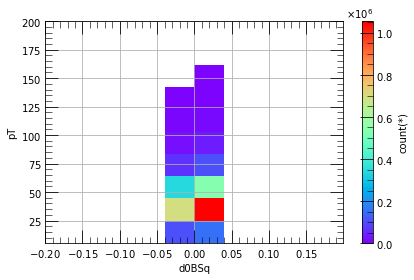

In [235]:
new_cmp = change_cmap_bkg_to_white("rainbow")

selec = abs(vdf_concat.eta) < 0.2 
x_lim = [min(equal_entry_bin_edges_qd0), max(equal_entry_bin_edges_qd0)]
y_lim = [min(equal_entry_bin_edges_pT), max(equal_entry_bin_edges_pT)]
# d0BSq_lim = 
vdf_concat.plot(vdf_concat.d0BSq, vdf_concat.pT, 
                limits=[x_lim, y_lim], 
                colormap=new_cmp,
                selection=[selec],
               shape=(10,10) )
                #, grid=)

# plt.savefig("/Users/Jake/Desktop/pT_vs_d0__test1.pdf", dpi=500)

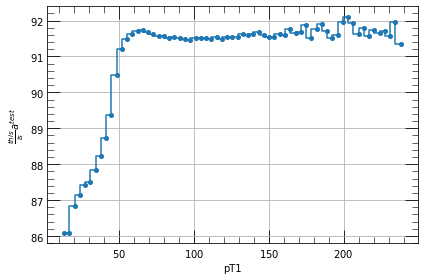

In [24]:
vdf.plot1d(vdf.pT1, what='mean(massZ)', ylabel=r"$\frac{this}{is} a^{test}$")

/Users/Jake/anaconda3/lib/python3.7/site-packages/vaex/image.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgba_dest[:, :, c][[mask]] = np.clip(result[[mask]], 0, 1)


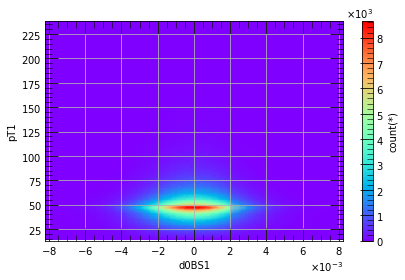

In [36]:
vdf.plot(vdf.d0BS1, vdf.pT1, colormap='rainbow', selection=[None, vdf.d0BS1 < .002, None], background_color='black',)
plt.savefig("/Users/Jake/Desktop/test1.png")

# Split stuff below into their own scripts. 

In [ ]:
%%time

kbin_test = KinematicBin(df_MC_2016, 
                    n_evts=15541434, 
                    massZ_cut_ls=[60,120],
                    eta_cut_ls=[0.0, 2.5], 
                    pT_cut_ls=[0, 1000], 
                    d0q_cut_ls=[-10, 10],
                    d0_type='BS',
                    dR_cut=0.008,
                    use_ptotal_instead=False, 
                    verbose=True)

In [ ]:
# Drop the extraneous columns in Filippo's samples. 

mystr = "massZ_vtx,massZ_vtx_FSR,massErrZ_vtx,massErrZ_vtx_FSR,massZ_vtxChi2,massZ_vtx_BS,massZ_vtx_BS_FSR,massErrZ_vtx_BS,massErrZ_vtx_BS_FSR,massZ_vtxChi2_BS,vtx_pT1,vtx_pT2,vtx_eta1,vtx_eta2,vtx_phi1,vtx_phi2,vtx_BS_pT1,vtx_BS_pT2,vtx_BS_eta1,vtx_BS_eta2,vtx_BS_phi1,vtx_BS_phi2,vtx_pT_FSR1,vtx_pT_FSR2,vtx_eta_FSR1,vtx_eta_FSR2,vtx_phi_FSR1,vtx_phi_FSR2,vtx_BS_pT_FSR1,vtx_BS_pT_FSR2,vtx_BS_eta_FSR1,vtx_BS_eta_FSR2,vtx_BS_phi_FSR1,vtx_BS_phi_FSR2"
drop_ls = mystr.split(",")

for ser in drop_ls:
    try:
        df_vaex_fromhdf5.drop(ser, inplace=True)
    except KeyError:
        continue

In [ ]:
get_there = 99
regions = 342
while get_there > 8:
    regions += 1
    print("Running over {} regions".format(regions))
    bin_reg_ls = find_equal_hist_regions_unbinned(all_pT_arr_upto200GeV, regions, verbose=False)
    get_there = bin_reg_ls[1]

In [53]:


def calc_dphi(phi2, phi1):
    """
    Calculate: phi2 - phi1 in the interval: [-pi, pi).
    Measure from lep1 to lep2. 
    Clockwise difference from 1 to 2 gives dphi < 0.
    Anticlockwise difference from 1 to 2 gives dphi > 0.
    
    Code converted from ROOT: https://root.cern.ch/doc/master/TVector2_8cxx_source.html#l00101
    
    FIXME: Implement arrays, in addition to Series and floats.
    
    Parameters
    ----------
    phi2 : float (or array-like)
        The azimuthal angle of, say, lepton 2. 
    phi1 : float (or array-like)
        The azimuthal angle of, say, lepton 1. 
        
    Returns
    -------
    dphi : float (or array-like)
        The difference in azimuthal angles in the range specified above.
    """
    
    if isinstance(phi1, vaex.expression.Expression):
        # Doesn't have a mask() method and doesn't like while loops.
        phi1.
    
    # Using a Series. 
    if isinstance(phi1, pd.core.series.Series):
        dphi = phi2 - phi1
        dphi = dphi.mask(dphi >= np.pi, dphi - 2*np.pi)
        dphi = dphi.mask(dphi < -np.pi, dphi + 2*np.pi)
        return dphi
    
    el
    
    # Using floats.
    else:
        dphi = phi2 - phi1
        while (dphi >= np.pi): dphi -= 2*np.pi  
        while (dphi < np.pi): dphi += 2*np.pi
        return dphi


In [57]:
# Most likely abandon this permutation of KinematicBin. 
# I attempted to make it work with vaex. It does not yet. 

class KinematicBin():

    def __init__(self, 
                df_original, 
#                  inpath_dataframe, 
                 n_evts, 
                 massZ_cut_ls, eta_cut_ls, pT_cut_ls, d0q_cut_ls, d0_type="BS", dR_cut=0.02, 
                 use_ptotal_instead=False, verbose=False):
        """
        Pass in a DataFrame (DF) and specify the eta and pT cuts to create a subset of DF.
        
        Parameters
        ----------
        df_original : pandas.DataFrame
            ROOT file converted into a DataFrame. Columns are branches. Rows are events.
        n_evts : int
            Number of events to search over - not guaranteed to find this many events! 
            Use '-1' to loop over all events in the df. 
        eta_cut_ls : list or array-like of floats
            A list of [eta_min, eta_max]. Example: [0.9, 1.8]
        pT_cut_ls : list or array-like of floats
            A list of [pT_min, pT_max]. Example: [5, 20]
        d0q_cut_ls : list or array-like of floats
            A list of values of d0*charge to cut on: [d0q_min, d0q_max]. E.g. [-0.01, 0.01]
        d0_type : str
            Which d0 to cut on: "BS" or "PV"
        use_ptotal_instead : bool
            Cut on total momentum instead of pT. 
            In most places, pT could stand for either p or pT (depending on 'use_ptotal_instead').
                Just be careful because not all places are adapted for p!
        dR_cut : float
            A cut to save events in which muon1 and muon2 both have dR < dR_cut.
        verbose : bool
            If True, get debug info and see where you are while the code runs.
            
        NOTE:
            The methods further down are more developed than the methods closer to __init__(). 
            Therefore, clean up and consolidate the earlier methods. 
        """
        if n_evts == -1:
            n_evts = len(df_original)
#         df = df_original[:n_evts].copy()    # Original DF. 
        df = df_original[:n_evts]    # Original DF. 
        
#         if n_evts > 0:
#             df = pd.read_hdf(inpath_dataframe, stop=n_evts)
#         elif n_evts == -1:
#             # Read in entire DF.
#             df = pd.read_hdf(inpath_dataframe)
#         else: 
#             raise ValueError("[ERROR] self.n_evts={} specified incorrectly.".format(self.n_evts))
        # Apparently this way is even slower than just copying the DF...
    
        self.n_evts_asked_for = n_evts
        self.n_evts_found = -999
        self.kinem_vals_after_selection = {}
        self.stats_dict = {}
        self.binned_df = None  # Will become the collection of events in which mu1 or mu2 passes all cuts.
        self.verbose = verbose
        
        self.cuts = ""
        self.sorted_cut_ls = []
        self.cut_dict = {}
        self.use_ptotal_instead = use_ptotal_instead
        self.p_str = "p" if (self.use_ptotal_instead) else "pT"
        self.p_str_latex = r"$p^{\mathrm{REC}}$" if (self.use_ptotal_instead) else r"$p_{T}^{\mathrm{REC}}$"

        self.massZ_min = massZ_cut_ls[0]
        self.massZ_max = massZ_cut_ls[1]        
        self.eta_min   = eta_cut_ls[0]
        self.eta_max   = eta_cut_ls[1]
        self.pT_min    = pT_cut_ls[0] 
        self.pT_max    = pT_cut_ls[1]         
        self.d0q_min   = d0q_cut_ls[0]
        self.d0q_max   = d0q_cut_ls[1]
        self.d0_type   = d0_type
        self.dR_cut    = dR_cut   
                
        self.apply_initial_cuts(df, verbose)
        
    def apply_initial_cuts(self, df, verbose):
        """
        Creates a subset of the original DataFrame in which initial cuts are applied.
        Cuts:
            pT
            eta
            d0
            massZ
            dR
        """
        # Cuts:
        eta_min   = self.eta_min  
        eta_max   = self.eta_max  
        pT_min    = self.pT_min   
        pT_max    = self.pT_max   
        d0q_min    = self.d0q_min
        d0q_max    = self.d0q_max
        dR_cut    = self.dR_cut   
        massZ_min = self.massZ_min
        massZ_max = self.massZ_max

        #--------------------------------------#
        #--- Save and manipulate variables. ---#
        #--------------------------------------#
        # GEN info. 
        eta1_gen_ser = df['genLep_eta1']
        eta2_gen_ser = df['genLep_eta2']
        phi1_gen_ser = df['genLep_phi1']
        phi2_gen_ser = df['genLep_phi2']
        pT1_gen_ser  = df['genLep_pt1']
        pT2_gen_ser  = df['genLep_pt2']

        # RECO info.
        eta1_rec_ser = df['eta1']
        eta2_rec_ser = df['eta2']
        phi1_rec_ser = df['phi1']
        phi2_rec_ser = df['phi2']
        pT1_rec_ser  = df['pT1']
        pT2_rec_ser  = df['pT2']
        
        # Store other variables.
        df['genLep_theta1'] = theta1_gen_ser = pseudorap2theta(eta1_gen_ser)
        df['genLep_theta2'] = theta2_gen_ser = pseudorap2theta(eta2_gen_ser)
        df['theta1'] = theta1_rec_ser = pseudorap2theta(eta1_rec_ser)
        df['theta2'] = theta2_rec_ser = pseudorap2theta(eta2_rec_ser)
        
        df['genLep_p1'] = pT1_gen_ser / np.sin( theta1_gen_ser )
        df['genLep_p2'] = pT2_gen_ser / np.sin( theta2_gen_ser )
        df['p1'] = pT1_rec_ser / np.sin( theta1_rec_ser )  # Total momentum
        df['p2'] = pT2_rec_ser / np.sin( theta2_rec_ser )  # Total momentum
                        
        df['delta_eta1'] = deta1_ser = eta1_rec_ser - eta1_gen_ser
        df['delta_eta2'] = deta2_ser = eta2_rec_ser - eta2_gen_ser
        df['delta_theta1'] = dtheta1_ser = theta1_rec_ser - theta1_gen_ser
        df['delta_theta2'] = dtheta2_ser = theta2_rec_ser - theta2_gen_ser

        # Remember that delta_phi requires special treatment:
        # -pi < delta_phi < pi
        df['delta_phi1'] = dphi1_ser = calc_dphi(phi1_rec_ser, phi1_gen_ser)
        df['delta_phi2'] = dphi2_ser = calc_dphi(phi2_rec_ser, phi2_gen_ser)

        df['delta_R1'] = dR1_ser = calc_dR(deta1_ser, dphi1_ser)
        df['delta_R2'] = dR2_ser = calc_dR(deta2_ser, dphi2_ser)
        df['delta_Rtheta1'] = dRtheta1_ser = calc_dR(dtheta1_ser, dphi1_ser)
        df['delta_Rtheta2'] = dRtheta2_ser = calc_dR(dtheta2_ser, dphi2_ser)
        
        df['delta_pT1'] = dpT1 = pT1_rec_ser - pT1_gen_ser
        df['delta_pT2'] = dpT2 = pT2_rec_ser - pT2_gen_ser
        
        df['delta_pToverpT1'] = dpT1 / pT1_gen_ser
        df['delta_pToverpT2'] = dpT2 / pT2_gen_ser
        
        df['delta_pToverRecpT1'] = dpT1 / pT1_rec_ser
        df['delta_pToverRecpT2'] = dpT2 / pT2_rec_ser     
        
        df['d0BSq1'] = df['d0BS1'] * df['Id1'].replace(13,-1).replace(-13,1)
        df['d0BSq2'] = df['d0BS2'] * df['Id2'].replace(13,-1).replace(-13,1)
        df['d0PVq1'] = df['d0PV1'] * df['Id1'].replace(13,-1).replace(-13,1)
        df['d0PVq2'] = df['d0PV2'] * df['Id2'].replace(13,-1).replace(-13,1)
        
        # Create masks.
        self.mask_massZ = mask_massZ = self.get_mask_massZ(df)
        
        self.mask_eta1, self.mask_eta2 = mask_eta1, mask_eta2 = self.get_mask_eta(df)
        self.mask_pT1,  self.mask_pT2  = mask_pT1,  mask_pT2  = self.get_mask_pT(df)
        self.mask_d0q1, self.mask_d0q2 = mask_d0q1, mask_d0q2 = self.get_mask_d0q(df)    
        self.mask_dR1,  self.mask_dR2  = mask_dR1,  mask_dR2  = self.get_mask_dR(df) 
        
        # Combine masks.
        self.mask_kinembin_lep1 = mask_massZ & mask_dR1 & mask_eta1 & mask_pT1 & mask_d0q1
        self.mask_kinembin_lep2 = mask_massZ & mask_dR2 & mask_eta2 & mask_pT2 & mask_d0q2

        # Keep all events in which either muon1 passed all selections or muon2 passed all. 
        self.all_masks = self.mask_kinembin_lep1 | self.mask_kinembin_lep2
        
        # Apply masks and update DataFrame.
        self.binned_df = df[self.all_masks]
#         del df
        self.n_evts_found = len(self.binned_df)
        
        # The cut_dict has been filled. Now convert it to an ordered list (alphabetically).
        self.sorted_cut_ls = sorted_cut_ls = [value for (key, value) in sorted(self.cut_dict.items())]
        self.cuts = combine_cut_list(sorted_cut_ls)
        
        if (self.verbose): 
            perc = self.n_evts_found / float(self.n_evts_asked_for) * 100.
            print("[INFO] Events found: {} ({:.3f}% of total events scanned)".format(self.n_evts_found, perc))
            print(r"using cuts: {}".format(self.cuts) + "\n")
      
    def get_mask_d0q(self, df):
        d0_type = self.d0_type
        if d0_type == "PV":
            mask_d0q1 = (self.d0q_min < df['d0PVq1']) & (df['d0PVq1'] < self.d0q_max)
            mask_d0q2 = (self.d0q_min < df['d0PVq2']) & (df['d0PVq2'] < self.d0q_max)
        elif d0_type == "BS":
            mask_d0q1 = (self.d0q_min < df['d0BSq1']) & (df['d0BSq1'] < self.d0q_max)
            mask_d0q2 = (self.d0q_min < df['d0BSq2']) & (df['d0BSq2'] < self.d0q_max)
            
        cuts_d0q = r"$%.3f < d_{0}^{\mathrm{%s}}*q(\mu) < %.3f$" % (self.d0q_min, self.d0_type, self.d0q_max)
        key = "d0{}q".format(self.d0_type)
        self.cut_dict[key] = cuts_d0q
        return mask_d0q1, mask_d0q2
        
    def get_mask_pT(self, df):
        if (self.use_ptotal_instead):
            mask_pT1 = (self.pT_min < df['p1']) & (df['p1'] < self.pT_max) 
            mask_pT2 = (self.pT_min < df['p2']) & (df['p2'] < self.pT_max)
        else:
            mask_pT1 = (self.pT_min < df['pT1']) & (df['pT1'] < self.pT_max) 
            mask_pT2 = (self.pT_min < df['pT2']) & (df['pT2'] < self.pT_max)
        
        cuts_p = r"$%d <$ %s $< %d$ GeV" % (self.pT_min, self.p_str_latex, self.pT_max)  # The string brings in its own '$'.
        self.cut_dict[self.p_str] = cuts_p
        return mask_pT1, mask_pT2

    def get_mask_eta(self, df):
        mask_eta1 = (self.eta_min < abs(df['eta1'])) & (abs(df['eta1']) < self.eta_max)
        mask_eta2 = (self.eta_min < abs(df['eta2'])) & (abs(df['eta2']) < self.eta_max)   
        
        cuts_eta = r"$%.2f < \left| \eta^{\mathrm{REC}} \right| < %.2f$" % (self.eta_min, self.eta_max)
        self.cut_dict["eta"] = cuts_eta
        return mask_eta1, mask_eta2

    def get_mask_dR(self, df):
        mask_dR1 = (df['delta_R1'] < self.dR_cut)
        mask_dR2 = (df['delta_R2'] < self.dR_cut)
        
        cuts_dR = r"$\Delta R < %.3f$" % (self.dR_cut)
        self.cut_dict["delta_R"] = cuts_dR
        return mask_dR1, mask_dR2
    
    def get_mask_massZ(self, df):
        mask_massZ = (self.massZ_min < df['massZ']) & (df['massZ'] < self.massZ_max)
        
        cuts_massZ = r"$%.1f < m_{\mu\mu} < %.1f$ GeV" % (self.massZ_min, self.massZ_max)
        self.cut_dict["massZ"] = cuts_massZ
        return mask_massZ    
    
    def apply_mask_get_data(self, kinem, lep_selection_type="", weave=False):
        """
        Return the kinematic lepton data which pass selections in this kinematic bin.
        E.g. Apply a boolean mask for event selection and retrieve all "delta_R1" values.

        Parameters
        ----------
        kinem : str
            A complete branch name in the DataFrame or root file. 
                E.g. "pT1", "genLep_pt2", "massZ"
        lep_selection_type : int
            The lepton's mask you want to apply.
            
            lep_selection_type = "1" -- get kinem values in which muon1 passes all selection criteria 
                                       (muon 2 may or may not pass selections).
            lep_selection_type = "2" -- get kinem values in which muon2 passes all selection criteria.
            lep_selection_type = "both" -- BOTH muons must pass selections to get data from event.
            lep_selection_type = "either" -- Either muon1, or muon2, or both must pass selections to get data from event.
            lep_selection_type = "independent" -- Get kinematic values for muon1 and muon2, with no restriction on which event they came from.
                Note: If kinem ends in "1" or "2", then the kinematic values of the other lepton are automatically grabbed.
        weave : bool
            Weave lep1 kinematic values and lep2 kinematic values together, so that slicing doesn't just give lep1. 
            Only relevant for "independent" selection.
        
        Returns
        -------
        kinem_vals : array 
            Kinematic values with chosen mask applied. 
            All values satisfy selection criteria for this kinematic bin.
        """
        df = self.binned_df
        mask1 = self.mask_kinembin_lep1
        mask2 = self.mask_kinembin_lep2
        
        if lep_selection_type == "1":
            # Only select events in which muon1 passes selections.
            mask = mask1
        elif lep_selection_type == "2":
            # Only select events in which muon2 passes selections.
            mask = mask2
        elif lep_selection_type == "both":
            # Only select events in which BOTH muon1 and muon2 pass selections.
            mask = mask1 & mask2
        elif lep_selection_type == "either":
            # Only select events in which BOTH muon1 and muon2 pass selections.
            mask = mask1 | mask2
        elif lep_selection_type == "independent":
            # Go through all muons in all events, without regard for other muon. 
            if kinem[-1] in ["1", "2"]:
                # Lep1 (or lep2) kinematic detected. Go find the other lepton's kinematic values.
                # FIXME: the variable massZ_vtxChi2 will be wrongly caught by this 'if' statement!
                kinem1 = kinem[:-1] + "1"
                kinem2 = kinem[:-1] + "2"
                kinem_vals1 = df[kinem1][mask1].values
                kinem_vals2 = df[kinem2][mask2].values
            else:
                # The kinematic doesn't depend on lep1 or lep2, like: massZ, GENmass2l, etc.
                kinem_vals1 = df[kinem][mask1].values
                kinem_vals2 = df[kinem][mask2].values
            
            if (weave):
                # Weave values together so that when slicing (like [:5]), you don't just grab kinem_vals1. 
                kinem_vals = np.array( weave_lists(kinem_vals1, kinem_vals2) )
            else: 
                kinem_vals = np.append(kinem_vals1, kinem_vals2)
        
            return kinem_vals
        
        else: 
            raise ValueError("[ERROR] `lep_selection_type` was not specified properly. Stopping now.")
        
        # A selection, other than "independent" was chosen.
        kinem_vals = df[kinem][mask].values
        
        return kinem_vals
    
    def make_2D_plot(self, 
                     x_kinem, y_kinem, 
                     x_bin_limits=[0, 1, 0.1], y_bin_limits=[0, 1, 0.1],
                     lep_selection_type="",
                     run_over_only_n_evts=-1, 
                     title="",
                     exclusive=True,
                     save_plot=False, save_as_png=False, outpath="",
                     ax=None):
        """
        Make a 2D plot. Two examples:
            (1) dphi vs. deta  
            (2) dphi vs. dtheta
        User can specify the binning along either axis. 
        This method plots only the muons which pass the selection 
        (as opposed to taking any event in which at least 1 muon pass kinematic bin criteria).
        
        Parameters
        ----------
        x_kinem : str
            The PARTIAL name of the kinematical variable to be plotted along x-axis. 
            Only works for kinematics which end with '1' or '2'.
            - Example: x_kinem="delta_theta" (for which there are two branches: "delta_theta1", "delta_theta2")
        y_kinem : str
            The PARTIAL name of the kinematical variable to be plotted along y-axis. 
            Only works for kinematics which end with '1' or '2'.
            - Example: y_kinem="delta_eta" (for which there are two branches: "delta_eta1", "delta_eta2")
        x_bin_limits : list or array-like of floats
            The bin limits on the horizontal axis. [bin_min_left_edge, bin_max_right_edge, bin_width]
            - Example: [-2.5, 2.5, 0.1]
        y_bin_limits : list or array-like of floats
            The bin limits on the vertical axis. [bin_min_left_edge, bin_max_right_edge, bin_width]
            - Example: [-2.5, 2.5, 0.1]
        lep_selection_type : str
            What kind of selection to perform on the leptons. Choices:
            #UPDATE
        run_over_only_n_evts : int
            Number of events to plot. Use '-1' to use all events in this kinembin.
        title : str
            Alternate title to put on plot. Overrides the default one made in this method.
        exclusive : bool
            Means "only put muons which passed all selections in this plot".
            FIXME: It must be set to True for now...
        save_plot : bool
            If True, save the plot as a pdf and possibly a png.
        save_as_png : bool
            If True, save the plot as a png.
        outpath : str
            Path to save plot.
        """           
        x_kinem1 = x_kinem + "1"
        x_kinem2 = x_kinem + "2"
        y_kinem1 = y_kinem + "1"
        y_kinem2 = y_kinem + "2"
        
        x_vals = self.apply_mask_get_data(x_kinem1, lep_selection_type=lep_selection_type, weave=True)
        y_vals = self.apply_mask_get_data(y_kinem2, lep_selection_type=lep_selection_type, weave=True)
        if run_over_only_n_evts != -1:
            x_vals = x_vals[:run_over_only_n_evts]
            y_vals = y_vals[:run_over_only_n_evts]

        # A special case to make comparison of (delta_phi vs. delta_theta) easy with (delta_phi vs. delta_eta).
        if (x_kinem1[:-1] == "delta_theta") and (y_kinem1[:-1] == "delta_phi"):
            x_vals *= -1

        #--- Make plots ---#
        if (ax is None):
            f, ax = plt.subplots(figsize=(12.8, 9.6))
        
        x_2D_bins, x_2D_bin_width = make_binning_array(x_bin_limits)
        y_2D_bins, y_2D_bin_width = make_binning_array(y_bin_limits) 
        
        # Plot 1: dphi vs. deta
        if lep_selection_type not in ["1","2"]:
            x_label = label_LaTeX_dict[x_kinem1]["independent_label"]
            y_label = label_LaTeX_dict[y_kinem1]["independent_label"]
        else:
            x_label_1 = label_LaTeX_dict[x_kinem1]["label"]
            x_label_2 = label_LaTeX_dict[x_kinem2]["label"]
            y_label_1 = label_LaTeX_dict[y_kinem1]["label"]
            y_label_2 = label_LaTeX_dict[y_kinem2]["label"]

            x_unit = label_LaTeX_dict[x_kinem2]["units"]
            y_unit = label_LaTeX_dict[y_kinem2]["units"]

            def prep_2D_label(label_1, label_2, unit, bin_width):
                label = "{},   {}".format(label_1, label_2)
                label += "\n" + "(bin width: {:.2E})".format(bin_width)
                if len(unit) > 0:
                    label =label.rstrip(")")
                    label += " {})".format(unit)  
                return label

            x_label = prep_2D_label(x_label_1, x_label_2, x_unit, x_2D_bin_width)
            y_label = prep_2D_label(y_label_1, y_label_2, y_unit, y_2D_bin_width)

        ax.set_xlabel(x_label)#, fontsize=label_size)
        ax.set_ylabel(y_label)#, fontsize=label_size)
        
        if len(title) > 0:
            title += "\n"
        cuts = "Selection type = {}:\n".format(lep_selection_type) 
        cuts += r"{}".format(self.cuts)
#         ax.set_title(title + cuts)#, fontsize=label_size)
    
        # Stats: 
#         stat_text_x = 0.1
        stat_text_x = 0.2
        stat_text_y = 0.83
        
        stats_ls = get_stats_2Dhist(x_vals, y_vals)
        leg_label = cuts + "\n" + make_stats_legend_for_2dhist(stats_ls)
        ax.text(stat_text_x, stat_text_y, leg_label, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        newcmp = change_cmap_bkg_to_white('rainbow')
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap=newcmp)
        plt.colorbar(im, ax=ax)

    def plot_kinem_genrec_comparison(self,
                              kinem_gen, kinem_rec, 
                              lep_selection_type="independent", 
                              x_limits=[-1, 1],
                              bin_limits=[-0.5,0.5,0.5], 
                              run_over_only_n_evts=-1,
                              ax=None, ax_ratio=None, log_scale=False
                              ):
            """
            FIXME: Need to implement under/overflow bins!

            Plots differences in kinematics. Includes a ratio plot at the bottom.
            
            Parameters
            ----------
            kinem_gen : str
                The generator-level kinematical variable from the column of DF.
                E.g. "genLep_pt1" or "genLep_eta2", etc.
            kinem_rec : str
                The reconsructed-level kinematical variable from the column of DF.
                E.g. "pT1" or "eta2", etc.
            x_limits : 2-element list
                The x_min and x_max to show along x_axis, for viewing purposes: [x_min, x_max]
            bin_limits : 3-element list
                [first_bin_left_edge, last_bin_right_edge, bin_width]
            ax : axes object
                An external axes object to pass in, on which the main plot will be plotted.
                If None, a default one will get created.
            ax_ratio : axes object
                An external axes object to pass in, on which the ratio plot will be plotted.
                If None, a default one will get created.
            log_scale : bool
                Set y-axis to log scale.
            """

            df = self.binned_df

            x_bin_arr, x_bin_width = make_binning_array(bin_limits)
            x_bin_centers_arr = shift_binning_array(x_bin_arr)

            #--- Get data ---#
            # Make sure you're plotting gen and rec of same lepton.
            if kinem_gen[-1] != kinem_rec[-1]:
                print("[WARNING] It seems you are plotting lepton 1 kinematics vs. lepton 2's!")
            if kinem_gen[-1] != lep_selection_type:
                err_msg = "[ERROR] You want to plot lep{} kinematics but you specified lep{} selection type.".format(kinem_gen[-1], lep_selection_type)
                raise ValueError(err_msg)

            # Chooses either lep1 or lep2. 
            data_rec = self.apply_mask_get_data(kinem_rec, lep_selection_type)
            data_gen = self.apply_mask_get_data(kinem_gen, lep_selection_type)

            if run_over_only_n_evts != -1:
                data_rec = data_rec[:run_over_only_n_evts]
                data_gen = data_gen[:run_over_only_n_evts]
                
            # Gen and Reco stats:
            stats_ls_gen = get_stats_1Dhist(data_gen)
            stats_ls_rec = get_stats_1Dhist(data_rec)

            #----------------#
            #--- Plot It. ---#
            #----------------#
            if (ax is None) or (ax_ratio is None):
                fig = plt.figure(figsize=(10,8))
                ax = fig.add_axes([0.17,0.33,0.825,0.54])  # [low_left_corner_x, low_left_corner_y, width, height]
                ax_ratio = fig.add_axes([0.17,0.12,0.825,0.20])

            leg_label_gen = make_stats_legend_for_1dhist(stats_ls_gen)
            leg_label_rec = make_stats_legend_for_1dhist(stats_ls_rec)

            leg_label_gen = leg_label_gen.replace("Entries", "GEN Entries")
            leg_label_rec = leg_label_rec.replace("Entries", "REC Entries")

            hist_bin_vals_gen, bin_edges_gen, _ = ax.hist(data_gen, bins=x_bin_arr, histtype='step', color='g', lw=2, label=leg_label_gen)
            hist_bin_vals_rec, bin_edges_rec, _ = ax.hist(data_rec, bins=x_bin_arr, histtype='step', color='b', label=leg_label_rec)

            hist_bin_vals_gen_modified = hist_bin_vals_gen.copy()
            hist_bin_vals_gen_modified[hist_bin_vals_gen == 0] = 0.0000000001
            ratio_vals = (hist_bin_vals_rec - hist_bin_vals_gen) / hist_bin_vals_gen_modified

            ax_ratio.errorbar(x_bin_centers_arr, ratio_vals, xerr=x_bin_width/2, color='black', ms=0, capsize=0, mew=0, ecolor='black', drawstyle='steps-mid', alpha=1)

            # Pretty up the plot. 
            ax_ratio.grid(which='major',axis='x')
            ax_ratio.grid(which='major',axis='y', ls='-')
            ax_ratio.grid(which='minor',axis='y')

            # Hide first tick label on y-axis, since it overlaps with ratio plot's tick label.
            a=ax.get_yticks().tolist()
            a[0]=''
            ax.set_yticklabels(a)

            # Hide main plot's x tick labels.
            plt.setp(ax.get_xticklabels(), visible=False)

            # Only show a few of the tick labels on ratio plot.
            n_tick_labels = 5
            ax_ratio.yaxis.set_major_locator(plt.MaxNLocator(n_tick_labels))
            ax_ratio.axhline(c='r', lw=2, ls='-')

            textsize_legend = 10
            textsize_axislabels = 12
            textsize_title = 12

            unit_gen = label_LaTeX_dict[kinem_gen]["units"]
            unit_rec = label_LaTeX_dict[kinem_rec]["units"]
            
            y_label = hist_y_label(x_bin_width, unit_gen)
            
            # Remember that ax shouldn't have an x-label; it's covered by the ax_ratio. 
            ax.set_ylabel(y_label, fontsize=textsize_axislabels)
#             ax.set_title(r"Selection: {}".format(self.cuts), fontsize=textsize_title)
            
            textbox_text = "Selection type = {}:\n".format(lep_selection_type) + self.cuts
            ax.text(0.025, 0.83, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
            plt.minorticks_on()

            x_min = x_limits[0]
            x_max = x_limits[1]
            ax.set_xlim([x_min, x_max])
            ax_ratio.set_xlim([x_min, x_max])
            ax_ratio.set_ylim([-0.12, 0.12])

            x_label_gen = label_LaTeX_dict[kinem_gen]["label"]
            x_label_rec = label_LaTeX_dict[kinem_rec]["label"]
            
            x_label = r"{}, {}".format(x_label_gen, x_label_rec)
            if len(unit_gen) > 0:
                x_label += " [{}]".format(unit_gen)
            ax_ratio.set_xlabel(x_label, fontsize=textsize_axislabels)
            ax_ratio.set_ylabel(r'$\frac{ (\mathrm{REC} - \mathrm{GEN}) }{ \mathrm{GEN} }$', fontsize=textsize_axislabels*1.5)

            y_max = max(max(hist_bin_vals_gen), max(hist_bin_vals_rec))
            ax.set_ylim([0, y_max*1.4])

            ax.legend(loc='upper right', framealpha=0.9, fontsize=textsize_legend)#, horizontalalignment='right')
            
            return ax, ax_ratio

    def plot_1D_kinematics(self, kinem="", lep_selection_type="independent", x_limits=[0,0], bin_limits=[0,0,0], run_over_only_n_evts=-1, ax=None, x_label="", y_label="", title="", y_max=-1, log_scale=False, iter_gaus=(False, 0)):
        """
        Make a histogram of a kinematical variable in the DF.  
        FIXME: 
            - Currently only works with kinem variables that end with `1` or `2`. 
            [ ] Eventually plot other quantities like massZ, etc.
        
        Parameters
        ----------
        kinem : str
            The full name of the kinematical branch/column ("delta_eta1", "delta_R2", "massZ", etc.)
        lep_selection_type : int
            Indicates the kind of selection to apply on leptons:
                lep_selection_type = "1"    -- Plot kinem values in which only lepton1 passed selections.
                lep_selection_type = "2"    -- Plot kinem values in which only lepton2 passed selections.
                lep_selection_type = "both" -- Plot kinem values in which lepton1 AND lepton2 passed selections.
                lep_selection_type = "either" -- Plot kinem values in which lepton1 OR lepton2 passed selections.
        x_limits : 2-element list
            The x_min and x_max to show along x_axis, for viewing purposes: [x_min, x_max]
        bin_limits : 3-element list
            [first_bin_left_edge, last_bin_right_edge, bin_width]   
        run_over_only_n_evts : int
            Number of events to put into histogram. 
        ax : axes object
            An external axes object to pass in, on which the main plot will be plotted.
            If None, a default one will get created.
        x_label : str
            Override the default x-label that would be produced.
        y_label : str
            Override the default y-label that would be produced.
        title : str
            Override the default title that would be produced.
        y_max : float
            The max y-value on vertical axis for viewing purposes.
            If set to -1, then automatic detection is used. 
        log_scale : bool
            Use log-scale on vertical axis.
        iter_gaus : 2-tuple
            If True, perform an iterative gaussian fit on the core N times.
            Syntax: (switch, N)
        """
        #--- Consistency checks ---#
        if ("BS" in kinem) or ("PV" in kinem):
            if self.d0_type not in kinem:
                err_msg = "[ERROR] The kinematic '{}' was specified but d0_type is '{}'.\nStopping now".format(kinem, self.d0_type)
                raise ValueError(err_msg)
                
        df = self.binned_df
        
        #--- Get data ---#
        data = self.apply_mask_get_data(kinem=kinem, lep_selection_type=lep_selection_type, weave=True)  # kinem must be a full name
            
        if run_over_only_n_evts != -1:
            data = data[:run_over_only_n_evts]
            
        if ax is None:
            # Axes doesn't exist yet. Make it.
            fig, ax = plt.subplots(figsize=(12.8,9.6))
            
        if bin_limits == [0,0,0]:
            # No bin limits specified, so use default binning for this kinematical variable.
            bin_limits = label_LaTeX_dict[kinem]["default_bin_limits"]
             
        if x_limits == [0,0]:
            # No x-limits specified, so use default x-limits for this kinematical variable.
            x_limits = label_LaTeX_dict[kinem]["default_x_limits"]
            
        unit = label_LaTeX_dict[kinem]["units"]
            
        x_bins, binw = make_binning_array(bin_limits)

        if len(x_label) == 0:
                # Both muons are being chosen. Change the labels.
            key = "label" if lep_selection_type in ["1","2"] else "independent_label"
            x_label = label_LaTeX_dict[kinem][key]
            if len(unit) > 0:
                x_label += " [{}]".format(unit)
            
        if len(y_label) == 0:
            # User didn't specify label, so make it.
            y_label = hist_y_label(binw, unit)
            
#         if len(title) == 0:
#             title = "Selections:\n" + self.cuts
        
        ax, bin_vals, bin_edges, stats = make_1D_dist(ax, data, x_limits, x_bins, 
                                                      x_label, y_label, title, y_max=-1, log_scale=False)
        
        # Nested dictionaries.
        # Initializing this particular kinematic bin's dictionary of stats.
        self.stats_dict[kinem] = {}
        self.stats_dict[kinem]['hist_stats'] = stats
        self.stats_dict[kinem]['bin_vals'] = bin_vals
        self.stats_dict[kinem]['bin_edges'] = bin_edges

        textbox_text = r"Selection type = {}:".format(lep_selection_type) + "\n"
        if lep_selection_type in ["1","2"]:
            textbox_text = textbox_text.replace("= ", r"$\mu$")
        textbox_text += self.cuts
        ax.text(0.03, 0.87, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
        if (iter_gaus[0]):
            # Do iterative fitting procedure.
            # Produce a dictionary of stats for these fits.
            best_guess_coeff = max(bin_vals)  # The Gaus coeff is usually around the max height of Gaus curve.
            best_guess_mean = stats[1]
            best_guess_stdev = stats[3]
            stats_dict, ax = iterative_fit_gaus(iter_gaus[1], bin_edges, bin_vals, 
                                                param_guess=[best_guess_coeff, best_guess_mean, best_guess_stdev],
                                                param_bounds=([0,-1000,-100], [999999999,1000,100]),
                                                ax=ax, draw_on_axes=True, verbose=self.verbose)
            # Use plotted kinem as the key for this dict of stats. 
            self.stats_dict[kinem]['fit_stats'] = stats_dict         
            
    def count_in_pT_eta_region_exclusive(self):
        """
        Return the number of muons in the DF subset which pass the eta and pT cuts. 
        'Exclusive' because only those muons which pass such cuts are counted 
        (as opposed to counting both muons from event just because one pass the cuts).
        """
        pass

In [58]:
%%time
kbin_test = KinematicBin(df_vaex_fromhdf5, 
                    n_evts=1000, 
                    massZ_cut_ls=[60,120],
                    eta_cut_ls=[0.0, 2.5], 
                    pT_cut_ls=[0, 1000], 
                    d0q_cut_ls=[-10, 10],
                    d0_type='BS',
                    dR_cut=0.008,
                    use_ptotal_instead=False, 
                    verbose=True)

AttributeError: 'Expression' object has no attribute 'replace'

In [ ]:
all_eta_arr = kbin_test.apply_mask_get_data("eta1", lep_selection_type="independent", weave=True)
# all_eta_arr2 = kbin2.apply_mask_get_data("eta1", lep_selection_type="independent", weave=True)

# all_pT_arr = kbin_test.apply_mask_get_data("pT1", lep_selection_type="independent", weave=True)
# all_qd0BS_arr = kbin_test.apply_mask_get_data("d0BSq1", lep_selection_type="independent", weave=True)

# all_pT_arr_upto200GeV = all_pT_arr[all_pT_arr <= 200]

In [ ]:
%%time
# bin_reg_ls_eta = find_equal_hist_regions_unbinned(all_eta_arr, 22, verbose=True)
# bin_reg_ls_eta2 = find_equal_hist_regions_unbinned(all_eta_arr2, 20, verbose=True)
# bin_reg_ls_pT = find_equal_hist_regions_unbinned(all_pT_arr, 10, verbose=False)
# bin_reg_ls_pT_upto200GeV = find_equal_hist_regions_unbinned(all_pT_arr_upto200GeV, 10, verbose=True, round_to_n_decimals=2)
# bin_reg_ls_qd0 = find_equal_hist_regions_unbinned(all_qd0BS_arr, 10, verbose=True, round_to_n_decimals=5)


print(collapse_eta_bin_edges(bin_reg_ls_eta))

In [ ]:
%%time
kbin_test.plot_1D_kinematics(kinem="eta1", lep_selection_type="independent", x_limits=[-2.5, 2.5], bin_limits=[-2.4,2.4,0.1], run_over_only_n_evts=-1, ax=None, x_label="", y_label="", title="", y_max=-1, log_scale=False, iter_gaus=(False, 0))

# Make $p_T$ distributions in different $\eta$ bins.

In [ ]:
%%time
%config InlineBackend.figure_format = 'retina'
# f, ax = plt.subplots(figsize=(12.8,9.6))

n_evts_scan = 2000000
# n_evts_scan = 300000
n_evts_keep = 1000000

df = df_MC_2016
d0_bin_limits = [-1, 1, 2]
massZ_cut_ls=[60,120]
pT_cut_ls=[5,1000]
eta_cut_ls=[
    [0.0, 0.2],
    [0.2, 0.4],
    [0.4, 0.6],
    [0.6, 0.8],
    [0.8, 1.0],
    [1.0, 1.2],
    [1.2, 1.4],
    [1.4, 1.6],
    [1.6, 1.8],
    [1.8, 1.9],
    [1.9, 2.0],
    [2.0, 2.1],
    [2.1, 2.2],
    [2.2, 2.3],
    [2.3, 2.4],
]

d0_type='BS'
dR_cut=0.008
use_ptotal_instead=False
fit_iters = 3

# outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_distributions_eta_binning/DY_MC_2016_3Mevts.pdf"
outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_distributions_eta_binning/test_09.pdf"
overwrite = True
verbose = True

#--- Automatons ---#
dir_ = os.path.dirname(outpath)
check_overwrite(outpath, overwrite)
makeDirs(dir_) 

org_kbin_ls = []
with PdfPages(outpath) as pdf:
    for eta_reg_ls in eta_cut_ls: 
        org_kbin = KinBinOrganizer(df, n_evts_scan, massZ_cut_ls, eta_reg_ls, pT_cut_ls, d0_type, dR_cut, use_ptotal_instead, verbose)
        org_kbin.make_kbin_ls_over_d0_range(d0_bin_limits)
        org_kbin.plot_dpToverpT_for_kbin_ls(kinem="pT1", lep_selection_type='independent', 
                                           x_limits=[-40, 250], bin_limits=[5, 200, 1], 
                                           run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, 
                                           iter_gaus=(False, fit_iters),
                                           make_pdf=True,
                                           pdf_obj=pdf    # If make_pdf=True, must pass in pdf object here!
                                           )  
#         org_kbin.get_iter_gaus_fit_stats("pT1")

        org_kbin_ls.append(org_kbin)
        plt.close("all")
    # Done looping over all eta regions.
    
    # Plot all graph lines on single axes. 
#     graph_ls = []
#     f, ax = plt.subplots()
#     for count,org_kb in enumerate(org_kbin_ls, 1):
#         graph = GraphLine(org_kb.d0_bin_arr_shifted, org_kb.fit_mean_ls, org_kb.fit_mean_err_ls)
#         graph.draw_graph("d0BSq1", "delta_pToverpT1", binning_type=binning_type, kbin_example=org_kb.kbin_ls[0], ax=ax, count=count)
#         # Note: if you want stats to show up on plot when doing draw_graph, then make sure count=1 at some point.
#         graph_ls.append(graph)
#     # Done looping over KinBinOrganizers.
#     plt.tight_layout()
#     pdf.savefig()
#     plt.close("all")

# Current project:

- [X] Discover best $p_T$ bins to use.
- [ ] Discover best $q*d_0$ bins to use in an $\eta, p_T$ bin.

In [ ]:
np.sum(((5 < df_MC_2016['pT1']) & (df_MC_2016['pT1'] < 7)))

In [ ]:
equal_entry_bin_dict = {
    "barrel" : {},
    "overlap" : {},
    "endcap" : {},
#     "pT_bins_barrel" : [5.0, 29.0, 35.0, 40.0, 45.0, 53.0, 200.0],
#     "pT_bins_overlap" : [5.0, 28.0, 35.0, 40.0, 45.0, 53.0, 200.0],
#     "pT_bins_endcap" : [5.0, 21.0, 29.0, 35.0, 40.0, 45.0, 53.0, 200.0],
}

In [ ]:
outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/find_best_binning__eta_pT_qd0/test6.pdf"
verbose = False

n_events_scan = 50000

n_divisions_start = 1
n_divisions_end = 16

d0q_cut_ls = [-1, 1]
massZ_cut_ls=[60,120]
pT_cut_ls=[5,1000]
eta_cut_ls=[1.0, 1.2]

d0_type='BS'
dR_cut=0.008
use_ptotal_instead = False
verbose = False
overwrite = True

bin_limits = [0,200,1]
x_limits=[-5,220]

#--------------------------------#
#---------- Automatons ----------#
#--------------------------------#
plt.style.use("cmsstyle_plot")

df = pd.read_hdf(dataframe)

dir_ = os.path.dirname(outpath)
check_overwrite(outpath,overwrite)
makeDirs(dir_) 

kb = KinematicBin(df_original=df,
                  n_evts=n_events_scan,
                  massZ_cut_ls=massZ_cut_ls,
                  eta_cut_ls=eta_cut_ls, 
                  pT_cut_ls=pT_cut_ls, 
                  d0q_cut_ls=d0q_cut_ls,
                  d0_type=d0_type,
                  dR_cut=dR_cut,
                  use_ptotal_instead=use_ptotal_instead, 
                  verbose=verbose)

with PdfPages(outpath) as pdf:

    # Must make distribution to divide it up into regions.
    kb.plot_1D_kinematics(kinem="pT1", lep_selection_type="independent", 
                          x_limits=x_limits, bin_limits=bin_limits, 
                          run_over_only_n_evts=-1, 
                          ax=None, x_label="", y_label="", title="", y_max=-1, log_scale=False, 
                          iter_gaus=(False, 0))
    pdf.savefig()
    plt.close("all")
    
    bin_vals = kb.stats_dict['pT1']['bin_vals']
    bin_edges = kb.stats_dict['pT1']['bin_edges']

    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(9.6,9.6))
    eta_cuts = kb.cut_dict['eta']

    division_ls = list(range(n_divisions_start, n_divisions_end+1))
    mean_perc_diff_ls = []

    for divisions in division_ls:
        pT_bins, this_dict = find_equal_hist_divisions(bin_edges, bin_vals, divisions, verbose=verbose)

        abs_perc_diff_ls = [abs(perc) for perc in this_dict.values()] 
        mean_perc_diff = np.mean(abs_perc_diff_ls)
        mean_perc_diff_ls.append(mean_perc_diff)

        x_vals = np.ones(len(pT_bins)) * divisions
        abs_perc_diff_ls.insert(0,0)

        ax1.errorbar(x=x_vals, y=pT_bins, yerr=abs_perc_diff_ls, linestyle="", markersize=2)

    ax2.plot(division_ls, mean_perc_diff_ls)

    ax1.set_title(r"%s" % eta_cuts)
    ax1.set_ylabel(r"$p_T$ bins [GeV]")
    ax2.set_xlabel(r"Equal-entry divisions in $p_T$ distribution")
    ax2.set_ylabel(r"mean(abs(% diff.)")

    pdf.savefig()
    plt.close("all")
    


# Suzanne's 2D plotter.

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.backends.backend_pdf

class Histogram():

    def __init__(self, filesave, xdata, title, ydata=None, zdata=None, isDataFrame=False, label=False, labelsize=7, comap=None, vmin=None, vmax=None, fmt=None, whiteBkgd=False):
        """
        This class takes in up to three distinct datasets. 
        If the dataset is input as a Pandas DataFrame, it only requires one input, which we take to be xdata. 
        The data will be handled differently depending on whether or not it is a dataframe, 
        so the isDataFrame boolean will be used to dictate how to handle the data. 
        The label input becomes the Seaborn annot input, which may be True, False, or a set of user-defined labels. 
        
        How to use a DataFrame:
            rows : x_data
            cols : 
        """

        self.filesave = filesave # Save the file using this name
        self.xdata = xdata 
        self.df_bool = isDataFrame # Is xdata a Pandas DataFrame?
        self.colmap = comap # Desired colormap
        self.label = label # Annotation label. (Set to True for numbers, False for empty, or customize with a user-generated label)
        self.labelsize = labelsize # Font size of label
        self.vmin = vmin # Colorbar min
        self.vmax = vmax # Colorbar max
        self.fmt = fmt # Format of label (Default is '.2g')
        # self.whitebkfg_bool = whiteBkgd
        self.title = title

        self.MakeHeatmap()

    def MakeHeatmap(self):
        # if self.whitebkfg_bool:
        #     print("[HISTOGRAM] Changing background to white.")
        #     self.colormap = self.ChangeBkgdToWhite()

        if self.df_bool:
            # If the data is a Pandas DataFrame, use this block to make a heatmap.
            plt.clf()
            self.hm = sb.heatmap(self.xdata, cmap=self.colmap, annot=self.label, annot_kws={"size": self.labelsize}, vmin=self.vmin, vmax=self.vmax, fmt=self.fmt)
            self.hm.invert_yaxis()
            # plt.show()
            self.hm.set_title(self.title, fontdict={'fontsize':16})
            # hm.figure.savefig(self.filesave)
            # print("[HISTOGRAM] File saved as {}".format(self.filesave))
        return self.hm

    def saveHist(self,filesave):
        self.hm.figure.savefig(filesave)

    # def ChangeBkgdToWhite(self, n=256):
    #     print('[HISTOGRAM] ChangeBkgdToWhite has been called.')
    #     tmp_colors = cm.get_cmap(self.colormap, n)
    #     newcolors = tmp_colors(np.linspace(0, 1, n))
    #     white = np.array([1, 1, 1, 1])    # White background (Red, Green, Blue, Alpha).
    #     newcolors[0, :] = white    # Only change bins with 0 entries.
    #     newcmp = ListedColormap(newcolors)
    #     return newcmp

In [ ]:

                      

    
    pdf_name  = f"{year}_{sample}_{bspv}__"
    title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
    # Example of Python magic: auto-concatenation of strings.
    pdf_name += (f"{title_str_pT_min}_pT_{pT_max}"
                 f"__{eta_min}_eta_{eta_max}"
                 f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}"
                 f"__wrt_{wrt}")
    pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
    
    outfile = os.path.join(outfile_path, pdf_name)
    if not os.path.exists(outfile_path):
        os.makedirs(outfile_path)
    if os.path.exists(outfile) and not (overwrite):
        print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
        return
        
    status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
    print(status)

            # Store info of this plot in a HistInfo object. 
            this_hist = HistInfo()            
            this_hist.year = year
            this_hist.sample = sample
            this_hist.bspv = bspv
            this_hist.d0_bin_window = [this_d0_bin, next_d0_bin]
            this_hist.x_axis_bounds_list = deltapT_range_ls[0:2] # 2-element list
            this_hist.eta_range = eta_cut_ls
            this_hist.pT_range = pT_cut_ls
            this_hist.massZ_cut = massZ_min
            this_hist.n_entries = n_entries
            this_hist.hist_mean = mean
            this_hist.hist_mean_err = mean_err
            this_hist.hist_stdev = stdev  # Spread of the data.
            this_hist.hist_stdev_err = stdev_err
            
            graph_info_ls.append(this_hist)
            
        return graph_info_ls


# Grids of 2D plots.

#### FIXME: 
- [ ] Use np.arrays to contain kbins for easy reshaping?
- [ ] Eventually merge into make_grid_of_2D_plots_FIXME.py

In [ ]:
%%time

n_evts = 10000

eta_bin_BARREL  = [0.0, 0.3]
eta_bin_OVERLAP = [0.8, 1.1]
eta_bin_ENDCAP  = [2.1, 2.4]


pT_bin_LOW1 = [5, 7]
pT_bin_LOW2 = [7, 10]
pT_bin_LOW3 = [10, 15]
pT_bin_LOW4 = [15, 20]
pT_bin_LOW5 = [20, 25]
pT_bin_LOW6 = [25, 30]

pT_bin_MED1 = [30, 35]
pT_bin_MED2 = [35, 40]
pT_bin_MED3 = [40, 45]
pT_bin_MED4 = [45, 50]
pT_bin_MED5 = [50, 55]
pT_bin_MED6 = [55, 60]

pT_bin_HIGH1 = [60, 65]
pT_bin_HIGH2 = [65, 70]
pT_bin_HIGH3 = [70, 75]
pT_bin_HIGH4 = [75, 80]
pT_bin_HIGH5 = [80, 90]
pT_bin_HIGH6 = [90, 100]

#--------------#
#--- Barrel ---#
#--------------#
# Low pT.
kbin_eta_BARREL_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# Med pT.
kbin_eta_BARREL_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_BARREL_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)


# #---------------#
# #--- Overlap ---#
# #---------------#
# # Low pT.
# kbin_eta_OVERLAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_OVERLAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_OVERLAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

# #---------------#
# #--- Endcap ---#
# #---------------#
# # Low pT.
# kbin_eta_ENDCAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_ENDCAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_ENDCAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

In [ ]:
dir(org_kbin)

In [ ]:
for key,val in org_kbin.__dict__.items():
    print("key is:", key, "   value is:", val)

In [ ]:
import matplotlib.pyplot as plt
from d0_Utils.d0_fns import calc_x_err_bins
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

class GraphLine():
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    def __init__(self, x_vals, y_vals, y_err_vals=np.zeros(0)):
        self.x_vals = x_vals
        self.y_vals = y_vals
#         self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
    def draw_graph(self, kinem_x, kinem_y, x_label="", y_label="", binning_type="", kbin_example=None, ax=None):
        """
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        """
        if binning_type not in ["eta", "pT"]:
            raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
#         #--- Check that things make sense: ---#
#         # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
#         wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
#         # Do same thing for binning in pT.
#         wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
#         if (wrong_eta_binning or wrong_pT_binning):
#             err_msg = f"\n\nBinning type ({binning_type}) specified, "
#             err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
#             raise RuntimeError(err_msg)
        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ecolor='k'
        ms=4  # marker size
        mec='k'  # marker edge color
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = label_LaTeX_dict[kinem_x]["independent_label"]
        if len(y_label) == 0:
            y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
            y_label += " (iterated Gaus fit mean)"
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
        low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        label_text = kbin_example.cut_dict[binning_type]
        ax.errorbar(self.x_vals, self.y_vals, xerr=[low_x_err, high_x_err], yerr=self.y_err_vals, fmt='.', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
        tmp_dict = kbin_example.cut_dict.copy()
        for key in list(kbin_example.cut_dict.keys()):
            if (binning_type in key) or ("d0" in key):
                del tmp_dict[key]
                    
        sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
        cut_str = combine_cut_list(sorted_cut_ls)
        textbox_text = cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        ax.text(0.025, 0.87, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
    def do_linear_fit(self, ax=None):
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8,9.6)) 
        
        # Do fit. 
        # Draw fit on axes.
        # return optimized parameters
        self.popt_linear = None

In [ ]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [ ]:
rescue_code()

In [ ]:
KinBin

In [ ]:
n_evts = 1000

# dataframe = pd.read_hdf('/Users/Jake/Desktop/MC_2016.h5')


massZ_cut_ls = [60,120]
d0q_cut_ls = [-0.01, 0.01]
d0_type = "BS"
dR_cut = 0.02
use_ptotal_instead = False
verbose = False

eta_regions = [
    [0.0, 0.3],
    [0.8, 1.1],
#     [2.1, 2.4]
]

# You should make there's always 18 different regions.
pT_regions = [
    [5, 7]  ,
    [7, 10] ,
    [10, 15],
    [15, 20],
    [20, 25],
#     [25, 30],
#     [30, 35],
#     [35, 40],
#     [40, 45],
#     [45, 50],
#     [50, 55],
#     [55, 60],
#     [60, 65],
#     [65, 70],
#     [70, 75],
#     [75, 80],
#     [80, 90],
#     [90, 100]
]

all_kbin_ls = []
for eta_reg in eta_regions:
    for pT_reg in pT_regions:
        all_kbin_ls.append( KinematicBin(df_MC_2016, n_evts, massZ_cut_ls, eta_reg, pT_reg, d0q_cut_ls, 
                                         d0_type, dR_cut, use_ptotal_instead, verbose) 
                          )

In [ ]:
kb1 = all_kbin_ls[0]
kb2 = all_kbin_ls[1]
kb3 = all_kbin_ls[2]

# First edition $dp_T/p_T^2$ vs. $d_0*q$ plotter

In [ ]:
def make_graph(*graph_tuple, binning_type='eta', verbose=False, save_plots=True, outpath='/Users/Jake/Desktop/'):
    """
    Make one deltapT vs. d0*charge plot, with as many graphs displayed as len(graph_tuple).
    graph_tuple contains many lists (graph_lsX) of histograms (HistInfo).
    
    graph_tuple = (
        graph_ls1,  # Each hist in this graph_ls all have identical cuts, but are made over different d0 bins.
        graph_ls2,  # This graph_ls2 may have slightly different cuts than graph_ls1.
        ...,
    )
    
    #--- Example ---#
    graph_ls1 = [HistInfo1, HistInfo2, ...]  # This list will generate 1 deltapT_vs_d0charge graph. 
    graph_ls2 = [HistInfo1, HistInfo2, ...]  # This list will generate another graph, but may have different cuts. 

    If binning_type is 'eta', then each graph_ls in graph_tuple should have the same pT cuts.
        This way, we can view different eta ranges while making sure pT cuts are all the same. 
    If binning_type is 'pT', then each graph_ls in graph_tuple should have the same eta cuts. 
    
    Returns
    -------
    graph_ls contains all the correct graph info to make a plot. 
    """    

        
    text_size_legend = 6
    text_size_ax_labels = 12
    text_size_tick_labels = 8
    text_size_title = 12


    # If binning in eta, then each graph should the same pT cuts. 
    if binning_type in 'eta':
        title_str += f'{example_graph.pT_range[0]}<' + r'$p_T$' + f'<{example_graph.pT_range[1]} GeV'
    elif binning_type in 'pT':
        title_str += f'{example_graph.eta_range[0]}<' + r'$\left| \eta \right|$' + f'<{example_graph.eta_range[1]}'
    ax.set_title(title_str)

    x_min = min([gr.d0_bin_window[0] for gr in example_graph_ls])
    x_max = max([gr.d0_bin_window[1] for gr in example_graph_ls])
    bin_edge_left = example_graph.d0_bin_window[0]
    bin_edge_right = example_graph.d0_bin_window[1]
    x_bin_width = abs(bin_edge_right - bin_edge_left)

    # ax.set_xlim([x_min*x_axis_scale, x_max*x_axis_scale])
    ax.set_xlim([-0.012, 0.012])
    ax.set_ylim([-0.005, 0.005])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
    # Gridlines.
    ax.grid(which='major',color='k', ls=':')

    x_bin_arr = np.arange(x_min, x_max+0.5*x_bin_width, x_bin_width)  # Includes all bin edges: very first to very last.
    x_n_bins = calc_num_bins(x_min, x_max, x_bin_width)

    # Calculate %diff for ratio plot.
    # acc_ZD_arr = np.array(acc_ZD, dtype=float)
    # acc_ALP_arr = np.array(acc_ALP, dtype=float)
    # acc_perc_diff_arr = (acc_ALP_arr - acc_ZD_arr) / acc_ZD_arr

    # Calculate errors on %diff.
    # acc_perc_diff_err_arr = getUncertOfFractionBinomial(acc_ALP_arr, acc_ZD_arr)

    # Plot the data.
    for count, gr_ls in enumerate(graph_tuple, 1):
        example_gr = gr_ls[0]
        y_vals = [gr.hist_mean for gr in gr_ls]
        y_vals_err = [gr.hist_mean_err for gr in gr_ls]
        if (verbose): 
            print(f'y_vals for graph_ls {count}:\n{y_vals}\n')

            
            
    
        plotname  = (f'deltapT_vs_d0{example_graph.bspv}timescharge_{example_graph.sample}{example_graph.year}_'
                     f'{binning_type}binning__')
        if binning_type in 'pT':
            plotname += f'{example_graph.eta_range[0]}_eta_{example_graph.eta_range[1]}'
        elif binning_type in 'eta':
            plotname += f'{example_graph.pT_range[0]}_pT_{example_graph.pT_range[1]}'
        plotname = make_str_title_friendly(plotname)
        
        fullpath = os.path.join(outpath, plotname)
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        plt.savefig(fullpath + '.pdf')
        plt.savefig(fullpath + '.png')
        print("Plot saved at:\n", fullpath)
    

# def make_kinem_comparison_plot(df, year, sample, 
# 
#     
#     pdf_name  = f"{year}_{sample}_"
#     title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
#     # Example of Python magic: auto-concatenation of strings.
#     pdf_name += (f"{kinem_gen}_vs_{kinem_rec}__{bspv}"
#                  f"__{title_str_pT_min}_pT_{pT_max}"
#                  f"__{eta_min_abs}_abs_eta_{eta_max_abs}"
#                  f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}")
#                 #  f"__wrt_{wrt}")
#     pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
#     
#     outfile = os.path.join(outfile_path, pdf_name)
#     if not os.path.exists(outfile_path):
#         os.makedirs(outfile_path)
#     if os.path.exists(outfile) and not (overwrite):
#         print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
#         return
#         
#     status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
#     print(status)
# 
# 
#         for k in range(len(d0_bin_arr)-1):
#             this_d0_bin = d0_bin_arr[k]
#             next_d0_bin = d0_bin_arr[k+1]
#             if bspv in 'BS':
#                 mask_d0BSxcharge = (this_d0_bin < d0BSxcharge_ser) & (d0BSxcharge_ser < next_d0_bin)
#                 # mask_d0BS2xcharge = (this_d0_bin < d0BS2xcharge_ser) & (d0BS2xcharge_ser < next_d0_bin)
#             elif bspv in 'PV':
#                 mask_d0PVxcharge = (this_d0_bin < d0PVxcharge_ser) & (d0PVxcharge_ser < next_d0_bin)
#                 # mask_d0PV2xcharge = (this_d0_bin < d0PV2xcharge_ser) & (d0PV2xcharge_ser < next_d0_bin)
# 
#                 
#  
#             # Store info of this plot in HistInfo objects. 
#             hist_gen = HistInfo()
#             hist_rec = HistInfo()            
#             hist_gen.year = year
#             hist_rec.year = year
#             hist_gen.sample = sample 
#             hist_rec.sample = sample
#             hist_gen.bspv = bspv 
#             hist_rec.bspv = bspv
#             hist_gen.d0_bin_window = [this_d0_bin, next_d0_bin] 
#             hist_rec.d0_bin_window = [this_d0_bin, next_d0_bin]
#             hist_gen.x_axis_bounds_list = x_range_ls[0:2] # 2-element list 
#             hist_rec.x_axis_bounds_list = x_range_ls[0:2] # 2-element list
#             hist_gen.eta_range = eta_cut_ls 
#             hist_rec.eta_range = eta_cut_ls
#             hist_gen.pT_range = pT_cut_ls
#             hist_rec.pT_range = pT_cut_ls
#             hist_gen.massZ_cut = massZ_min
#             hist_rec.massZ_cut = massZ_min
#             hist_gen.n_entries = n_entries_gen
#             hist_rec.n_entries = n_entries_rec
#             hist_gen.hist_mean = mean_gen
#             hist_rec.hist_mean = mean_rec
#             hist_gen.hist_mean_err = mean_err_gen
#             hist_rec.hist_mean_err = mean_err_rec
#             hist_gen.hist_stdev = stdev_gen
#             hist_rec.hist_stdev = stdev_rec  # Spread of the data.
#             hist_gen.hist_stdev_err = stdev_err_gen
#             hist_rec.hist_stdev_err = stdev_err_rec
#             
#             graph_info_gen_ls.append(hist_gen)
#             graph_info_rec_ls.append(hist_rec)
 

In [ ]:
%config InlineBackend.figure_format ='retina'

fig = plt.figure(figsize=(25.6,19.2))
ax = plt.subplot(221)
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 3))
ax = plt.subplot(222)
kbin.plot_1D_kinematics(kinem="delta_pToverRecpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))
ax = plt.subplot(223)
kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 4))
ax = plt.subplot(224)
kbin.plot_1D_kinematics(kinem="d0BSq2", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))

# Kinematics subplots.

In [ ]:
# kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.02, 0.02], bin_limits=[-0.008, 0.008, 0.0002], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))

In [ ]:
# hist_mean = kbin.stats_dict['delta_pToverpT1']['hist_stats'][1]
# hist_mean_err = kbin.stats_dict['delta_pToverpT1']['hist_stats'][2]
# fit_mean = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1]
# fit_mean_err = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1]

d0_bin_arr, d0_bin_width = make_binning_array(d0_bin_limits)
d0_bin_arr_shifted = shift_binning_array(d0_bin_arr)

if d0_bin_width < 0.0005:
    err_msg = f"WARNING: d0_bin_width ({d0_bin_width}) is too small (d0_bin_width < 0.0005).\nStopping now."
    raise ValueError(err_msg)    

# Make list of kinematic bins.
kbin_ls = []
with PdfPages(outpath) as pdf:
    for elem in range(len(d0_bin_arr)-1):
        # Make a kbin for each d0 bin.
        d0_this = d0_bin_arr[elem]
        d0_next = d0_bin_arr[elem+1]

        kbin = KinematicBin(df_MC_2016, 
                            n_evts=n_evts_scan, 
                            massZ_cut_ls=[60,120],
                            eta_cut_ls=[0.0, 0.3], 
                            pT_cut_ls=[40, 50], 
                            d0q_cut_ls=[d0_this, d0_next],
                            d0_type='BS',
                            dR_cut=0.02,
                            use_ptotal_instead=False, 
                            verbose=True)
        kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
        kbin_ls.append(kbin)
        
        pdf.savefig()
        plt.close()

# Get graph values.
hist_mean_ls     = []
hist_mean_err_ls = []
fit_mean_ls      = []
fit_mean_err_ls  = []
for kb in kbin_ls:
    hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
    hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
    fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
    fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])

al=1  # alpha=0 is transparent
elw=1  # error bar line width
ecolor='k'
ms=4  # marker size
mec='k'  # marker edge color
cs=1  # cap size
mew=0.7  # marker edge width

low_x_err, high_x_err = calc_x_err_bins(d0_bin_arr_shifted)
    
fig, ax = plt.subplots(figsize=(12.8,9.6))

# legend_text = ""
# ax.text(k, y, "Some words", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#             legend_text = f'{example_gr.pT_range[0]} <' + r' $p_T$ ' + f'< {example_gr.pT_range[1]}'
ax.errorbar(d0_bin_arr_shifted, fit_mean_ls, xerr=[low_x_err, high_x_err], 
            yerr=fit_mean_err_ls, fmt='s', label="some cuts go here?",
        #color=color_dict[count], 
            elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
ax.legend(loc='upper left', framealpha=al)#, fontsize=text_size_legend)